## Welcome!

The goal for today is to introduce data analysis through an applied project. Given the variety in experience in this group, three options are available for you:

1. Beginner: We will work through this file together, line by line, as I explain reasoning and answer questions as we go along.
2. Experienced: You independently work through `appointments_skeleton.ipynb`,  a file similar to this one but without the answers. 
3. Independent: Using the MIMIC2 ICU data, predict mortality or length of stay (https://www.kaggle.com/drscarlat/mimic2-original-icu/version/1).

We will reconvene as a group at 7:30 and share what each one did, debrief on learnings, and answer any remaining questions.

Choose your adventure!

------

## Missed Appointments

A clinic is in trouble, as they have been wasting resources every month when staff is available but rooms are empty. We have been tasked with understanding why people who receive treatment instructions do not show up at the next appointment time. How often are patients missing appointments? Who is missing most often? What are the contributing factors for missing appointments?

This example is based on a Kaggle dataset and strongly inspired by Veronika Rovnik's blog post.

Blog: https://towardsdatascience.com/exploratory-analysis-python-kaggle-data-b0afb6ec1788

Data: https://www.kaggle.com/joniarroba/noshowappointments

## Set up
We start by importing the main libraries we will use. The big one for data munging is `pandas`.

In [1]:
# For data processing:
import numpy as np
import pandas as pd
# For plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# For modeling:
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### Read in data
After you’ve downloaded the data from Kaggle, the next step is to build a pandas DataFrame based on the CSV data.

In [2]:
df = pd.read_csv('appts_dat.csv')
# Naming your data "df" is common practice, and you will see many examples do that

### Profile the data
Before cleaning the data, let’s check the overall quality of the data and data types of each column.
What columns does the data have? How many patients are available?

In [3]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
print("Number of records (patients): ", df.shape[0])
print("Number of columns (features): ", df.shape[1])

Number of records (patients):  110527
Number of columns (features):  14


In our analysis, what is the primary ouotcome, or the characteristic of interest?

The columns are called "features" of the data. They are also called "covariates", "predictors", or even "correlates". These are the characteristics we will use to estimate our primary outcome.

### Fix the column names
You may have noticed that our features contain typing errors.
Let’s rename misspelled column names.

Old column name goes first

In [7]:
df = df.rename(columns={'Hipertension': 'Hypertension', 'SMS_received': 'SMSReceived'})
df.head()
# * There's another column that is misspelled. Rename that one too. 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMSReceived,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [8]:
df["Handicap"] = df["Handcap"]

df.drop(columns=["Handcap"], axis="columns", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hypertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  SMSReceived     110527 non-null  int64  
 12  No-show         110527 non-null  object 
 13  Handicap        110527 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [9]:
list(df.columns)

['PatientId',
 'AppointmentID',
 'Gender',
 'ScheduledDay',
 'AppointmentDay',
 'Age',
 'Neighbourhood',
 'Scholarship',
 'Hypertension',
 'Diabetes',
 'Alcoholism',
 'SMSReceived',
 'No-show',
 'Handicap']

### Cleaning & preparing the data content
Cleaning the data is an art that should be mastered in the first place before starting any data science or machine learning project. It makes data easier to investigate and build visualizations. Through this process you will also start to "get to know" your data, and therefore understand how to best levarage it during modeling.


After you’ve checked the data types of features, you may have noticed that `ScheduledDay` and `AppointmentDay` features have an `object` data type.
To make dealing with date features easies, let’s convert the type of ‘ScheduledDay’ and ‘AppointmentDay’ to `datetime64[ns]`. You need this to get access to useful methods and attributes.

In [10]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  float64       
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  object        
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hypertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  SMSReceived     110527 non-null  int64         
 12  No-show         110527 non-null  object        
 13  Handicap        110527 non-null  int64         
dtypes: datetime64[ns](2), float64(1), in

We can also rename “No-show” column to “Presence” and its values to ‘Present’ and ‘Absent’ so as to avoid any misinterpretation.

In [11]:
# * First we create a new column, as a function of the No-show column.
df['Presence'] = df['No-show'].apply(lambda x: 'Present' if x == "No" else 'Absent')
# * We can now remove the No-show column.
df = df.drop('No-show', axis= 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  float64       
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  object        
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hypertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  SMSReceived     110527 non-null  int64         
 12  Handicap        110527 non-null  int64         
 13  Presence        110527 non-null  object        
dtypes: datetime64[ns](2), float64(1), in

## Feature engineering
Now that the data we have is neatly organized, let's go back to our goal: To understand why people who receive treatment instructions do not show up at the next appointment time. In other words, what are the contributing factors for missing appointments?

Given this goal, we ask ourselves: is there something we can calculate from what we have that will help us more directly answer the question? This is called _feature engineering_. Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model using machine learning or statistical modeling.

In this case, we have the date the appointment was scheduled and the date of the actual appointment, but what may be helpful is the **time** between these two. So, we can add a new feature to the dataset — ‘Waiting Time Days’ to note how long the patient needs to wait for the appointment day.

In [13]:
df['WaitingTimeDays'] = df['AppointmentDay'] - df['ScheduledDay']
df['WaitingTimeDays'] = df['WaitingTimeDays'].dt.days
# * Can also be done in a single line:
# TODO df['WaitingTimeDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

We could also believe that the day of the week may matter. Let's add that.

In [14]:
df['WeekDay'] = df['AppointmentDay'].apply(lambda x: x.weekday())
replace_map = {'WeekDay': {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}}
df.replace(replace_map, inplace=True)

In [15]:
df["DayOfWeek"] = df["AppointmentDay"].dt.dayofweek

df["DayOfWeek"].value_counts()

2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: DayOfWeek, dtype: int64

In [16]:
# * A quick sanity check the resulting variable:
df["WeekDay"].value_counts(dropna=False)

Wednesday    25867
Tuesday      25640
Monday       22715
Friday       19019
Thursday     17247
Saturday        39
Name: WeekDay, dtype: int64

"Feature engineering" may sound boring and inconsequential, but it is actually an essential step in any analysis. On a per-hour (and certainly per-computation), it is orders of magnitude more impactful than model parameter tuning. Also note that the term feature engineering is mostly used in macchine learning. In other fields it is just a part of the "data wrangling" or "data preparation" process.

Here is a great article with more details and examples: https://medium.com/@mortenjorgensen_16022/feature-engineering-the-secret-sauce-to-applied-machine-learning-e61ac5963405

## Check for Missing Data

Before going any further, let’s see if there are null values in each column.

In [17]:
df.isnull().sum()

PatientId          0
AppointmentID      0
Gender             0
ScheduledDay       0
AppointmentDay     0
Age                0
Neighbourhood      0
Scholarship        0
Hypertension       0
Diabetes           0
Alcoholism         0
SMSReceived        0
Handicap           0
Presence           0
WaitingTimeDays    0
WeekDay            0
DayOfWeek          0
dtype: int64

We are lucky (and rather unrealistic) — there are no null values in our dataset! 

What would we have done if there were missing values? What effect would that choice have had in our future conclusions?


## Exploratory Analysis
We can now get a bit deeper into each variable (or feature) and see what kind of patients we have.

For numeric variables we can get a quick sense of what's happening with a table showing numeric summaries for each.
_What 3 things can you learn about the data from this table?_

In [18]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,Handicap,WaitingTimeDays,DayOfWeek
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.321026,0.022248,10.183702,1.858243
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.466873,0.161543,15.254996,1.371672
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000,3.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,179.000000,5.000000


In [19]:
df["Hypertension"].value_counts()

0    88726
1    21801
Name: Hypertension, dtype: int64

For categorical variables, we can count the number in each group:

In [20]:
df["Diabetes"].value_counts()

0    102584
1      7943
Name: Diabetes, dtype: int64

This is helpful, but we care more about the relative counts (percentages):

In [21]:
# We can get the proportion by adding `normalize=True`
df["Presence"].value_counts(normalize=True)

Present    0.798067
Absent     0.201933
Name: Presence, dtype: float64

In [22]:
df["Neighbourhood"].value_counts(normalize=True)

JARDIM CAMBURI                 0.069820
MARIA ORTIZ                    0.052521
RESISTÊNCIA                    0.040090
JARDIM DA PENHA                0.035077
ITARARÉ                        0.031793
                                 ...   
ILHA DO BOI                    0.000317
ILHA DO FRADE                  0.000090
AEROPORTO                      0.000072
ILHAS OCEÂNICAS DE TRINDADE    0.000018
PARQUE INDUSTRIAL              0.000009
Name: Neighbourhood, Length: 81, dtype: float64

In [23]:
df["Gender"].value_counts(normalize=True)

F    0.649977
M    0.350023
Name: Gender, dtype: float64

In [24]:
pd.crosstab(df["Gender"], df["Presence"])

Presence,Absent,Present
Gender,,
F,14594,57246
M,7725,30962


We can also make a bar plot of Presence: 

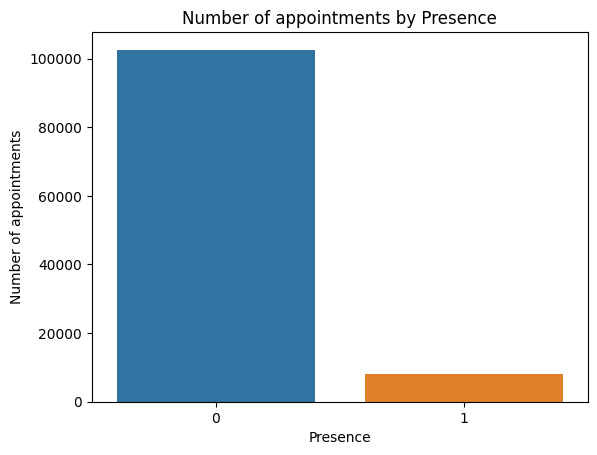

In [25]:
counts = df.groupby('Diabetes').count()[['AppointmentID']].reset_index()
counts
# Let's use a simple bar chart in Seaborn to compare counts for the two drugs
# There are several different ways to do the plotting - this is my preferred style,
# but you might prefer different syntax
fig = sns.barplot(data=counts, x='Diabetes', y='AppointmentID')
plt.title('Number of appointments by Presence')
plt.ylabel('Number of appointments')
plt.xlabel('Presence')
plt.show(fig)

### Data Analysis
We now get into some variable relationships. Remember our question: who is missing appointments?

Let's look at the weekday variable we created. Are people more likely to miss an appointment on certain days?

Which day has the most missed appointments?


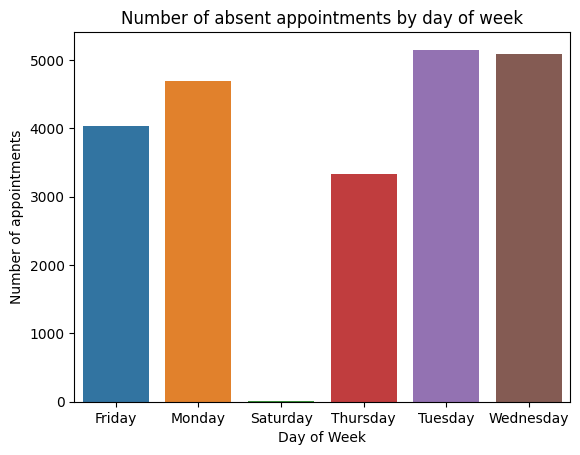

In [26]:
df_absent = df[df['Presence']=="Absent"]
counts = df_absent.groupby('WeekDay').count()[['AppointmentID']].reset_index()
# ! counts
# Let's use a simple bar chart in Seaborn to compare counts for the two drugs
# There are several different ways to do the plotting - this is my preferred style,
# but you might prefer different syntax
fig = sns.barplot(data=counts, x='WeekDay', y='AppointmentID')
plt.title('Number of absent appointments by day of week')
plt.ylabel('Number of appointments')
plt.xlabel('Day of Week')
plt.show(fig)

What can we learn from this plot?
We see that Saturday and Thursday have the two fewest missed appointments. Does that mean that Saturday patients are the most compliant?

Let's look at the data a different way, as a table of proportion of missed appointments by day oof week:

In [27]:
pd.crosstab(index=df['WeekDay'], columns=df['Presence'], normalize='index')

Presence,Absent,Present
WeekDay,,
Friday,0.212261,0.787739
Monday,0.206471,0.793529
Saturday,0.230769,0.769231
Thursday,0.193541,0.806459
Tuesday,0.200936,0.799064
Wednesday,0.196892,0.803108


What does the table tell us? Do you prefer the table or the plot?

While the barplot above is not "wrong", it does not answer the question we have, and can actually be misleading. What would be a better barplot?

<AxesSubplot: xlabel='Presence', ylabel='proportion'>

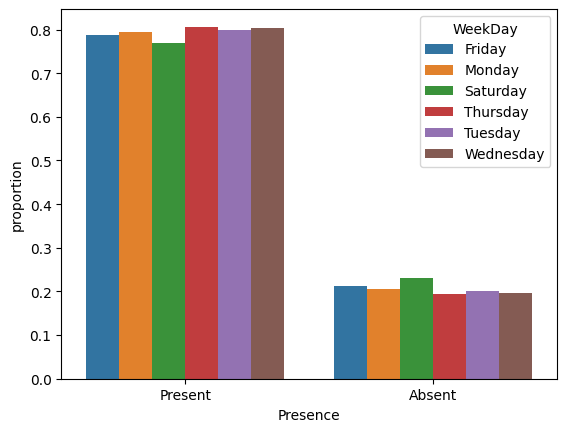

In [28]:
x, y, hue = "Presence", "proportion", "WeekDay"
hue_order = ["0", "1"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

<AxesSubplot: xlabel='Gender', ylabel='proportion'>

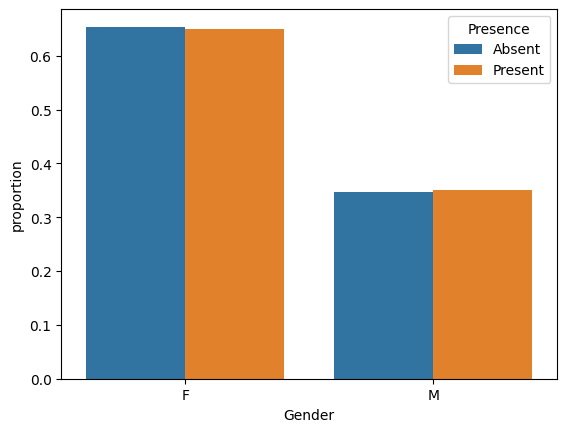

In [29]:
x, y, hue = "Gender", "proportion", "Presence"
hue_order = ["0", "1"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

Take 5 minutes and decide two more plots you'd like to make with this dataset to get to know it better. You do not have to actually code them (unless you want). The act of thinking through what would be helpful is crucial, and is often overlooked, and we get caught up in the joy of coding.



_One plot would be ..._
_Another plot would be ..._

### Model

Ok! So now we have a sense of the data available, and in broad stokes what is going on.

Let's return to our question. A helpful technique to go from a business or scientific question to something we can create a model for is to rephrase our question probabilistically. In this case we could ask: _what is the expected probability patient A will miss the next an appointment?_

To start, let's say we know nothing else about the patient. What is our best guess of this probability?

_The best guess is the overall proportion of patients who missed an appointment, 20%_


Now, I tell you that the appointment is scheduled for a Saturday. Do you update your guess?


_Yes, now my guess is the overall average for Saturday appointments, which is 23%_

Finally, I tell you that the patient is female, and all sorts of other characteristics. How would you update your guess now?

_With several characteristics, we can't use contingency tables and instead move to statistical models, or use machines to do our learning :)_

#### Decision Tree

One very powerful model is a `decision tree`. This framework is useful for non-linear relationships between features, when a regression may not be flexible enough. It also produces a very explainable model.

Great summary of trees and figures: https://mljar.com/blog/visualize-decision-tree/

Start by creating `X`, a subset of `df` with the *predictors* to use. Also create Y, with only the outcome:

In [30]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'SMSReceived', 'Handicap', 'Presence',
       'WaitingTimeDays', 'WeekDay', 'DayOfWeek'],
      dtype='object')

In [34]:
X = df[[
 # 'Gender',
 'Age',
 #'Neighbourhood',
 'Scholarship',
 'Hypertension',
 'Diabetes',
 'Alcoholism',
 'Handicap',
 'SMSReceived',
 'WaitingTimeDays',
# 'WeekDay'
    ]]
y = df['Presence']

Now, instantiate the tree and fit the model.

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Instantiate model object
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf

DecisionTreeClassifier(max_depth=5, random_state=0)

In [36]:
# Fit it to our data
mod_tree = clf.fit(X, y)

In [37]:
mod_tree

DecisionTreeClassifier(max_depth=5, random_state=0)

How can we summarize how well our model worked? Since we are classifying into categories, calculate the accuracy:

In [48]:
# Predict on same data
preds = mod_tree.predict(X)
# Create manual "confusion matrix"
df_wpred = df.copy()
df_wpred['pred'] = preds
# ! pd.crosstab(index=df_wpred['pred'], columns=df_wpred['Presence'], normalize='index')
pd.crosstab(index=df_wpred['pred'], columns=df_wpred['Presence'])

Presence,Absent,Present
pred,,
Absent,21,10
Present,22298,88198


Of course, there's an automatic way to do this:

In [39]:
# Accuracy
mod_tree.score(X,y)

0.7981669637283197

In [40]:
(9497+84152)/(9497+84152+4056+12822)

0.8472952310295222

Is this a good, excellent, or poor accuracy?

How can we improve our model?

Some may have noticed that we did not use all of the features in our dataset. Which did we leave out?

The tree model _only_ takes numeric variables. So what do we do with something like Weekday? Well, in order to use the categorical variables, we need to transform them into numeric.

The way we do this is by making dummy variables, also known as one-hot-encoding. Do this for Gender, and WeekDay.

In [41]:
# Change the class from "object" to categorical
for col in ['Gender','WeekDay', 'Neighbourhood']:
    df[col] = df[col].astype('category')
# * add dummy variables  
df2 = pd.get_dummies(data=df,columns=['Gender','WeekDay'])

Now, let's fit a second model with these features included.

In [54]:
X_2 = df2[[
  'Gender_F',
  'Gender_M',
 'Age',
 #'Neighbourhood',
 'Scholarship',
 'Hypertension',
 'Diabetes',
 'Alcoholism',
 'Handicap',
 'SMSReceived',
 # ! 'WaitingTimeDays',
 'WeekDay_Monday',
 'WeekDay_Tuesday',
 'WeekDay_Wednesday',
 'WeekDay_Thursday',
 'WeekDay_Friday',
 'WeekDay_Saturday'
    ]]

In [55]:
clf_2 = DecisionTreeClassifier(random_state=0,max_depth=5)
mod_tree_2= clf_2.fit(X_2, y)

In [56]:
mod_tree_2.score(X_2,y)

0.7980855356609697

In [57]:
mod_tree_2.feature_names_in_

array(['Gender_F', 'Gender_M', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived',
       'WeekDay_Monday', 'WeekDay_Tuesday', 'WeekDay_Wednesday',
       'WeekDay_Thursday', 'WeekDay_Friday', 'WeekDay_Saturday'],
      dtype=object)

Take a look at the tree using a text representation. What can you conclude?

In [46]:
text_representation = tree.export_text(clf_2)
print(text_representation)

|--- feature_9 <= 0.50
|   |--- feature_2 <= 20.50
|   |   |--- feature_2 <= 6.50
|   |   |   |--- feature_13 <= 0.50
|   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_14 >  0.50
|   |   |   |   |   |--- class: Present
|   |   |   |--- feature_13 >  0.50
|   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_2 >  1.50
|   |   |   |   |   |--- class: Present
|   |   |--- feature_2 >  6.50
|   |   |   |--- feature_0 <= 0.50
|   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |--- class: Present
|   |   |   |--- feature_0 >  0.50
|   |   |   |   |--- feature_12 <= 0.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_12 >  0.50
|   |   |   |   |   |--- class: Present
|   |--- feature_2 >  20.50
|   |   |--- feature_9 <= -0.50
|   |   |   |--- class: Absent
|   |   |--- fea

One important way to understand the model is with the *variable importance*. Although different models calculate it slightly differently, the idea is to rank features according to how useful they are in the prediction.

Let's find it for our tree. Were all features helpful?

In [58]:
importance = mod_tree_2.feature_importances_
print(importance)

[0.00000000e+00 0.00000000e+00 3.68373253e-01 1.23880137e-02
 1.76748209e-03 0.00000000e+00 5.07335094e-03 2.24828730e-03
 5.70077913e-01 3.16257967e-03 1.94191460e-03 1.67109525e-03
 5.00558805e-04 3.27955522e-02 0.00000000e+00]


In [59]:
# Put importance in a dataframe to make it readable
importance_dat = {'Var':mod_tree_2.feature_names_in_,
                  'Importance':importance}
importance_dat = pd.DataFrame(importance_dat)
print(importance_dat)

                  Var  Importance
0            Gender_F    0.000000
1            Gender_M    0.000000
2                 Age    0.368373
3         Scholarship    0.012388
4        Hypertension    0.001767
5            Diabetes    0.000000
6          Alcoholism    0.005073
7            Handicap    0.002248
8         SMSReceived    0.570078
9      WeekDay_Monday    0.003163
10    WeekDay_Tuesday    0.001942
11  WeekDay_Wednesday    0.001671
12   WeekDay_Thursday    0.000501
13     WeekDay_Friday    0.032796
14   WeekDay_Saturday    0.000000


In [60]:
df["Presence"].value_counts(normalize=True)

Present    0.798067
Absent     0.201933
Name: Presence, dtype: float64

In [ ]:
df

Let's fit a model with only the top most important variables. Does our accuracy change much?

In [51]:
X_3 = df[[
 'Age',
 'WaitingTimeDays'
    ]]
clf_3 = DecisionTreeClassifier(random_state=0, max_depth=5)
mod_tree_3 = clf_3.fit(X_3, y)
mod_tree_3.score(X_3,y)

0.7981307734761642

Pick one of the top variables, and make a plot. 

C:\Users\miqui\AppData\Local\Temp\ipykernel_13560\1555472423.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Absent', 'Present'])


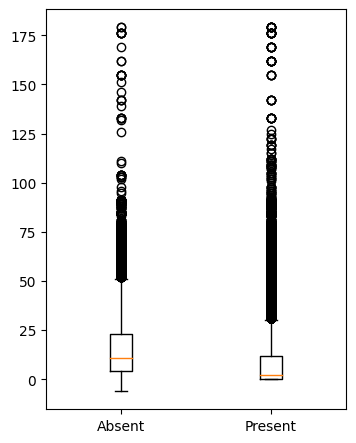

In [52]:
# Boxplot of WaitingTimeDays by wheter appoointment was missed.

days_abs = df[df['Presence']=="Absent"]["WaitingTimeDays"]
days_pre = df[df['Presence']=="Present"]["WaitingTimeDays"]

data = [days_abs, days_pre]

fig = plt.figure(figsize =(3, 4))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# x-axis labels
ax.set_xticklabels(['Absent', 'Present'])

# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()

In [53]:
text_representation = tree.export_text(clf_3)
print(text_representation)

|--- feature_1 <= 0.50
|   |--- feature_0 <= 20.50
|   |   |--- feature_0 <= 6.50
|   |   |   |--- feature_0 <= 3.50
|   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_0 >  0.50
|   |   |   |   |   |--- class: Present
|   |   |   |--- feature_0 >  3.50
|   |   |   |   |--- feature_0 <= 5.50
|   |   |   |   |   |--- class: Present
|   |   |   |   |--- feature_0 >  5.50
|   |   |   |   |   |--- class: Present
|   |   |--- feature_0 >  6.50
|   |   |   |--- feature_0 <= 17.50
|   |   |   |   |--- feature_1 <= -0.50
|   |   |   |   |   |--- class: Absent
|   |   |   |   |--- feature_1 >  -0.50
|   |   |   |   |   |--- class: Present
|   |   |   |--- feature_0 >  17.50
|   |   |   |   |--- feature_1 <= -0.50
|   |   |   |   |   |--- class: Absent
|   |   |   |   |--- feature_1 >  -0.50
|   |   |   |   |   |--- class: Present
|   |--- feature_0 >  20.50
|   |   |--- feature_1 <= -0.50
|   |   |   |--- class: Absent
|   |   |--- feature

Other tree visualizations: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

### What about SMS?

This clinic has been trying to mitigate this problem, and started sending SMS (text messages) to some of its patients. Did that effort work? In this analysis it was not one of the most important variables. Does that mean they should stop? Why or why not?

### Extensions
Another model we can use when we have only two variables is logistic regression. This is a very powerful model when we have smaller data, and produces interpretable results. Beware that the default implementation is a _penalized_ logistic regression.

For any model, we will similarly look at accuracy, and variable importance. Other metrics such as recall and precision (or sensitivity and specificity) can be quite useful.

One aspect we did not cover here is cross validation. In reality, we would want to make sure we train the model with one subset of the data, and test the accuracy of another. Otherwise, we are very likely to over-fit and get a high accuracy that is not actually representative of how the model would perform with new data.


## Wrap up

This was only a glimpse into what we could do in an analysis of this dataset. If you'd like to see other analyses, go to the Kaggle repository ( https://www.kaggle.com/joniarroba/noshowappointments/code).